Connected to Python 3.11.5

# Sentiment Analysis Mini Project: Amazon Musical Instruments Reviews



This notebook details a mini project focused on sentiment analysis of Amazon reviews for musical instruments. My interest in Natural Language Processing (NLP) has motivated me to undertake this project, as I believe sentiment analysis can significantly influence business development. By analyzing sentiments in customer reviews, businesses can gain crucial insights into customer perceptions and preferences, which can drive strategic decisions and enhance customer satisfaction.

## Libraries

### Data Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### NLP Text Libraries

In [2]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shash\AppData\Roaming\nltk_data...


### EDA Analysis



In [4]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

### Feature Engineering



In [6]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

### Model Selection and Evaluation



In [7]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## The Dataset
The dataset that we will use is taken from Kaggle website and can be downloaded here:

Amazon Musical Instruments Reviews

There are two formats available of the dataset: JSON and CSV. We will use the CSV one in this project.

Overall, the dataset talks about the feedback received after the customers purchased musical instruments from Amazon.



### Read The Dataset

In [9]:
dataset = pd.read_csv("Musical_instruments_reviews.csv")

### Shape of the dataset

In [10]:
dataset.shape

(10261, 9)

The dataset has 10261 rows and 9 columns

---

## Data Preprocessing 

### Checking the null values

In [12]:
dataset.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In the dataset, there are two columns with null values: reviewText and reviewerName. While the reviewerName column is not crucial for our analysis, the reviewText column is important. Since removing rows with missing values in reviewText would result in the loss of potentially valuable information (given that the ratings and summaries provided by customers are significant for our model), we should handle these null values differently.

Instead of dropping the rows, we'll fill the missing values in the reviewText column with an empty string. This approach allows us to retain all rows and ensures that the analysis remains comprehensive, even though the number of missing values is relatively small.

### Filling the Missing Values

In [14]:
dataset.reviewText.fillna(value = "", inplace= True)

### Concatinate "reviewText" and "summary" Columns

In [15]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns= ["reviewText", "summary"] , axis= 1 , inplace = True)

### Statistic Description of The Dataset



In [16]:
dataset.describe(include="all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


Based on the description, customer ratings range from 1 to 5. The average rating for musical instruments sold is 4.48. Additionally, we have created a new column named reviews to combine both the summary and reviewText columns.

### Percentages of Ratings Given from The Customers



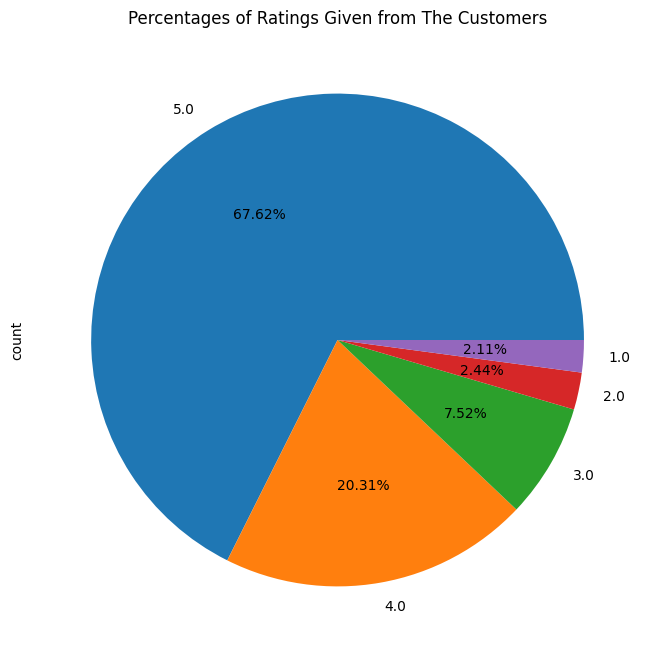

In [17]:
dataset.overall.value_counts().plot(kind="pie" , legend=False , autopct = "%1.2f%%" , fontsize= 10 , figsize= (8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()
          

In [18]:
# Get the counts of each rating
rating_counts = dataset['overall'].value_counts()
print("Rating Counts:")
print(rating_counts)

Rating Counts:
overall
5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: count, dtype: int64


The chart indicates that the majority of musical instruments sold on Amazon receive the highest rating of 5.0, suggesting that these products are generally in good condition. The distribution of ratings is as follows:

- **5.0**: 6,938 reviews
- **4.0**: 2,084 reviews
- **3.0**: 772 reviews
- **2.0**: 250 reviews
- **1.0**: 217 reviews

For our analysis, we categorize ratings as follows:

- Ratings above 3 are considered positive.
- Ratings equal to 3 are categorized as neutral.
- Ratings below 3 are deemed negative.

Given the low number of negative reviews relative to the positive ones, this imbalance could impact the performance of our model. It's important to account for this potential issue when developing our predictive algorithms.


### Labelling Products Based On Ratings Given



Our dataset currently lacks a dependent variable, meaning we do not have a specific prediction target. To address this, we will create a sentiment label for each row based on the ratings provided. The sentiment categorization will be as follows:

- **Positive**: For ratings greater than 3.0
- **Neutral**: For ratings equal to 3.0
- **Negative**: For ratings less than 3.0

This categorization will allow us to define our target variable and proceed with sentiment analysis based on these labels.


In [19]:
def Labelling(Rows):
    if(Rows["overall"] > 3.0):
        Label = "Positive"
    elif(Rows["overall"] < 3.0):
        Label = "Negative"
    else:
        Label = "Neutral"
    return Label

In [20]:
dataset["sentiment"] = dataset.apply(Labelling , axis= 1)

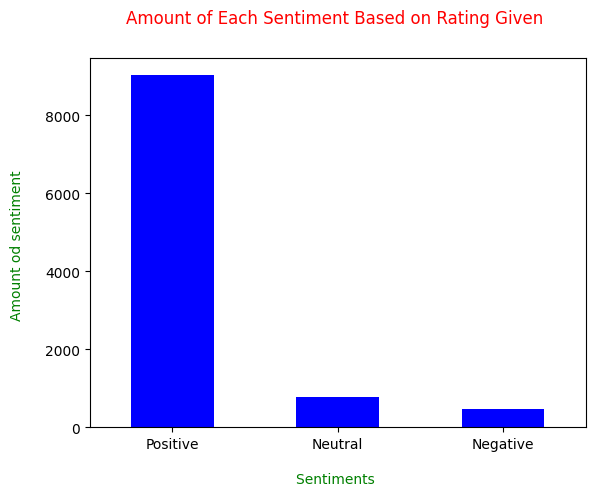

In [22]:
dataset["sentiment"].value_counts().plot(kind= "bar" , color = "blue")
plt.title("Amount of Each Sentiment Based on Rating Given " , loc = "center" , color = "red" , pad = 25)
plt.xlabel("Sentiments ", color = "green" , fontsize = 10, labelpad= 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount od sentiment ", color = "green" , fontsize = 10 , labelpad= 15)
plt.show()

In this stage, we could convert the sentiment labels into numeric values for more straightforward analysis. However, for the sake of this experiment, we will keep the labels as categorical and consider numeric conversion at a later stage. Additionally, the graph indicates that the majority of our data is classified as positive sentiment, which aligns with our previous exploration.

---

# Text Preprocessing
### Text Cleaning

In [26]:
def Text_Cleaning(Text):
    # Lowercase the texts 
    Text = Text.lower()

    # Cleaning the punctuations in the text

    punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    Text = Text.translate(punc)

    # Removing numbers in the text 
    Text = re.sub(r'\d+', '', Text)

    # Remove possible links 
    Text = re.sub('https?:\S+ | www\.\S+', '', Text)

    # Deleting newlines

    Text = re.sub('\n', '', Text)

    return Text

### Text Processing 

In [58]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

Stopwords = ' '.join(Stopwords)

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still 
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))


### Applying The Functions



In [27]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))

# Exploratory Data Analysis
### Overview of The Dataset

In [30]:
dataset.head(n = 9)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5.0,1356048000,"12 21, 2012",good bought another one love heavy cord gold c...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5.0,1390089600,"01 19, 2014",used monster cable year good reason lifetime w...,Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3.0,1353024000,"11 16, 2012",use cable run output pedal chain input fender ...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",5.0,1215302400,"07 6, 2008",perfect epiphone sheraton ii monster cable wel...,Positive


With the overview above, we know that for sentiment analysis that we will do, reviews is important to our model and we should use this aspect as our feature. 

By using this feature, we will need to predict what our sentiment will be classified into.

### About Other Features

In [31]:
dataset.describe(include= 'all')

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


Next, let's return to the statistical description of our dataset. Based on the exploration, it seems that certain features, such as `reviewerID`, `asin`, `reviewerName`, and `unixReviewTime`, may not significantly impact sentiment analysis. Specifically, the `helpful` feature, which often holds values like `[0, 0]`, indicates that most users did not utilize this voting option. Consequently, it appears that this feature might not be crucial for our model.

Here’s a summary of the data:

| **Feature**      | **count** | **unique** | **top**                  | **freq** | **mean** | **std**  | **min** | **25%** | **50%** | **75%** | **max**  |
|------------------|-----------|------------|--------------------------|----------|----------|----------|---------|---------|---------|---------|----------|
| reviewerID       | 10,261    | 1,429      | ADH0O8UVJOT10            | 42       | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| asin             | 10,261    | 900        | B003VWJ2K8               | 163      | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| reviewerName     | 10,234    | 1,397      | Amazon Customer          | 66       | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| helpful          | 10,261    | 269        | [0, 0]                   | 6,796    | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| overall          | 10,261    | NaN        | NaN                      | NaN      | 4.49     | 0.89     | 1.00    | 4.00    | 5.00    | 5.00    | 5.00     |
| unixReviewTime   | 10,261    | NaN        | NaN                      | NaN      | 1.36e+09 | 3.78e+07 | 1.10e+09 | 1.34e+09 | 1.37e+09 | 1.39e+09 | 1.41e+09 |
| reviewTime       | 10,261    | NaN        | 01 22, 2013              | 40       | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| reviews          | 10,261    | 1,570      | good string five star    | 3        | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |
| sentiment        | 10,254    | 3          | Positive                 | 9,022    | NaN      | NaN      | NaN     | NaN     | NaN     | NaN     | NaN      |

Given that the `helpful` feature's most common value is `[0, 0]`, it suggests that it may not provide significant insights for our model. Therefore, we might decide to exclude it from our analysis.


---

### Polarity, Review Length, and Word Counts

To justify our analysis before, we will dive further into the dataset a bit more from the polarity of the texts, also from the words used in the reviews. We will generate some new columns in our dataset and visualize it.

### Polarity

In [32]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

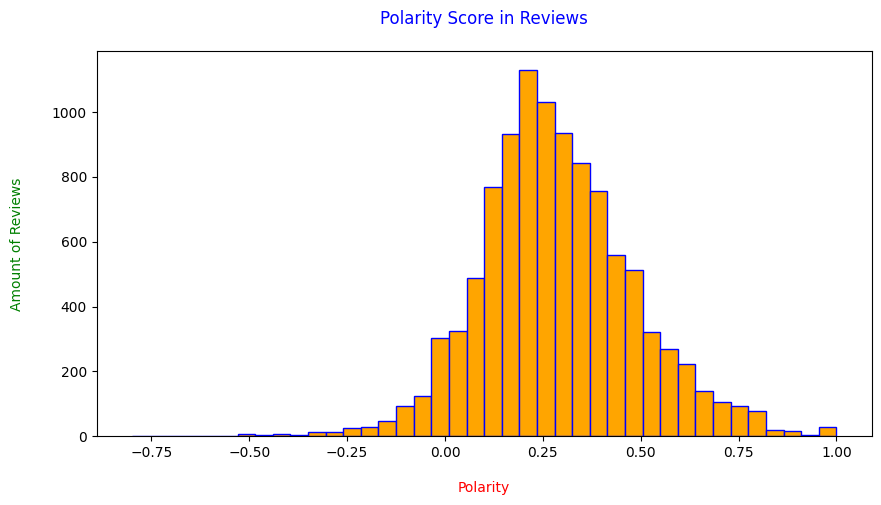

In [33]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

Reviews with negative polarity will fall within the range of `[-1, 0)`, neutral reviews will be assigned a value of `0.0`, and positive reviews will fall within the range of `(0, 1]`.

The histogram above confirms that most reviews are categorized as having positive sentiments, which supports our earlier analysis. Statistically, the histogram indicates that the distribution of sentiments is not a standard normal distribution but still aligns with our previous findings. In summary, our sentiment analysis aligns with the histogram, confirming that the majority of reviews are positive.


### Review Length



In [34]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)


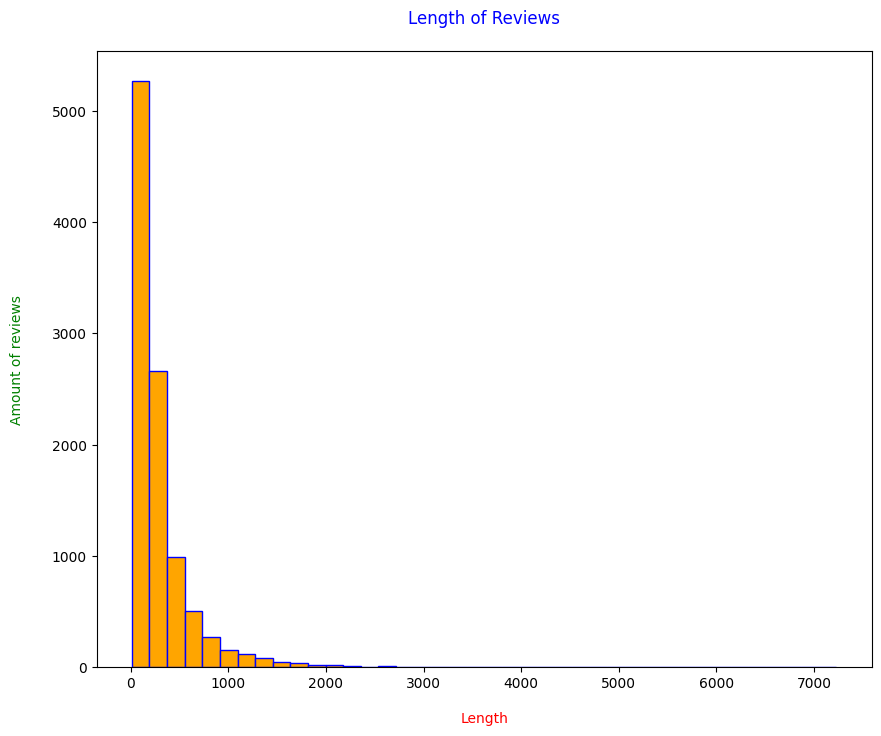

In [37]:
dataset["length"].plot(kind= "hist", bins = 40 , edgecolor = 'blue', linewidth = 1 , color='orange', figsize = (10,8))
plt.title("Length of Reviews" , color = "Blue" , pad= 20)
plt.xlabel("Length" , labelpad= 15 , color= "red")
plt.ylabel("Amount of reviews" , labelpad = 20 , color = "green")
plt.show()

Based on this, we know that our review has text length between approximately 0-1000 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 1000 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.

### Word Counts

In [40]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x : len(str(x).split()))


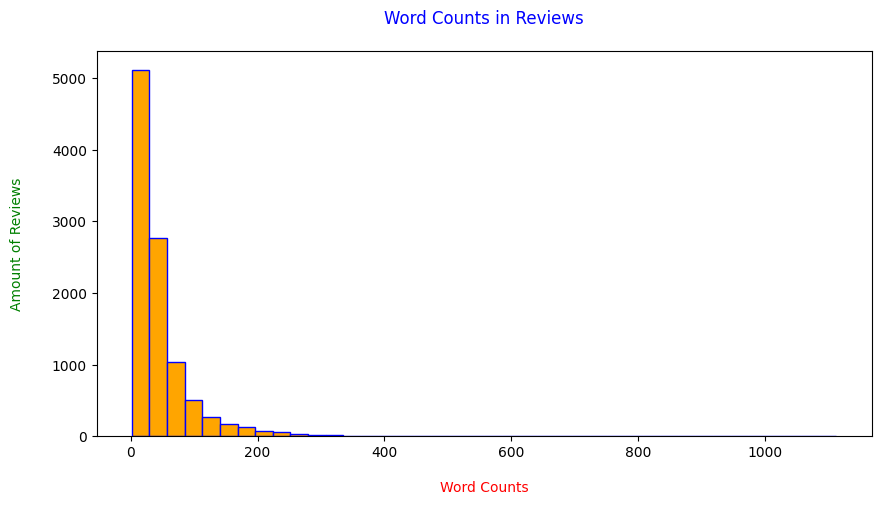

In [41]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

From the figure above, we infer that most of the reviews consist of 0-200 words. Just like before, the distribution is skewed right and the calculation is affected by our text preprocessing phase before

---

# N-Gram Analysis


### N-Gram Function



An N-Gram function is a natural language processing (NLP) tool used to split text into contiguous sequences of \(n\) items (words, characters, or symbols). N-Grams are a foundational concept in text processing and computational linguistics, commonly used for various applications, including text classification, language modeling, and information retrieval.

Here's a brief overview:

- **Unigram**: An N-Gram where \(n = 1\). It represents individual words.
  - Example: "The cat" → ["The", "cat"]
- **Bigram**: An N-Gram where \(n = 2\). It represents pairs of consecutive words.
  - Example: "The cat" → ["The cat"]
- **Trigram**: An N-Gram where \(n = 3\). It represents triples of consecutive words.
  - Example: "The cat sat" → ["The cat sat"]

N-Grams can be used for:

- **Text Analysis**: Helps in understanding text patterns and frequency of word sequences.
- **Language Modeling**: Assists in predicting the next word in a sequence.
- **Text Classification**: Enhances feature extraction for machine learning models.
- **Spell Checking**: Identifies context-based spelling errors.
- **Information Retrieval**: Improves search algorithms by considering word sequences.


In [59]:
def Gram_Analysis(Corpus , Gram , N):
    #Vectorizer
    Vectorizer = CountVectorizer(stop_words= Stopwords , ngram_range = (Gram, Gram))

    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)

    # N-Gram frequency
    Count = ngrams.sum(axis=0)

    #list of Words
    words = [(word, Count[0,idx])for word, idx in Vectorizer.vocabulary_.items()]

    #Sorting Decsending with Key = Count
    words = sorted(words, key = lambda x:x[1] , reverse= True)

    return words[:N]

### Filter The DataFrame Based On Sentiments



In [51]:
# Use dropna() so the base DataFrame is not affected

Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

### Unigram of Reviews Based on Sentiments



In [61]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got "her she that wasn hasn aren't isn't those and from theirs yourself wouldn your aren nor too such that'll re me than haven ve an you're mightn only if again were here under isn him are was below shouldn up don't be being into hasn't some did once his it needn't over what o have down which shan it's through about is having am should've with weren't own out above their very few on ll there t do because most all each this has now so doesn't further does them haven't i just of she's when d shouldn't doing while to ma didn between weren any by where they been who or before the won't its wouldn't you'd these ain himself will doesn ours other a why themselves more against my itself same hadn't yourselves off both mightn't mustn ourselves should our mustn't for had s needn don until myself but m hers then shan't you'll couldn you herself he whom yours can didn't won wasn't as couldn't we y you've hadn at in no how after during" instead.

In [65]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

In [66]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got "her she that wasn hasn aren't isn't those and from theirs yourself wouldn your aren nor too such that'll re me than haven ve an you're mightn only if again were here under isn him are was below shouldn up don't be being into hasn't some did once his it needn't over what o have down which shan it's through about is having am should've with weren't own out above their very few on ll there t do because most all each this has now so doesn't further does them haven't i just of she's when d shouldn't doing while to ma didn between weren any by where they been who or before the won't its wouldn't you'd these ain himself will doesn ours other a why themselves more against my itself same hadn't yourselves off both mightn't mustn ourselves should our mustn't for had s needn don until myself but m hers then shan't you'll couldn you herself he whom yours can didn't won wasn't as couldn't we y you've hadn at in no how after during" instead.

In [67]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got "her she that wasn hasn aren't isn't those and from theirs yourself wouldn your aren nor too such that'll re me than haven ve an you're mightn only if again were here under isn him are was below shouldn up don't be being into hasn't some did once his it needn't over what o have down which shan it's through about is having am should've with weren't own out above their very few on ll there t do because most all each this has now so doesn't further does them haven't i just of she's when d shouldn't doing while to ma didn between weren any by where they been who or before the won't its wouldn't you'd these ain himself will doesn ours other a why themselves more against my itself same hadn't yourselves off both mightn't mustn ourselves should our mustn't for had s needn don until myself but m hers then shan't you'll couldn you herself he whom yours can didn't won wasn't as couldn't we y you've hadn at in no how after during" instead.

In [68]:

# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got "her she that wasn hasn aren't isn't those and from theirs yourself wouldn your aren nor too such that'll re me than haven ve an you're mightn only if again were here under isn him are was below shouldn up don't be being into hasn't some did once his it needn't over what o have down which shan it's through about is having am should've with weren't own out above their very few on ll there t do because most all each this has now so doesn't further does them haven't i just of she's when d shouldn't doing while to ma didn between weren any by where they been who or before the won't its wouldn't you'd these ain himself will doesn ours other a why themselves more against my itself same hadn't yourselves off both mightn't mustn ourselves should our mustn't for had s needn don until myself but m hers then shan't you'll couldn you herself he whom yours can didn't won wasn't as couldn't we y you've hadn at in no how after during" instead.

In [69]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got "her she that wasn hasn aren't isn't those and from theirs yourself wouldn your aren nor too such that'll re me than haven ve an you're mightn only if again were here under isn him are was below shouldn up don't be being into hasn't some did once his it needn't over what o have down which shan it's through about is having am should've with weren't own out above their very few on ll there t do because most all each this has now so doesn't further does them haven't i just of she's when d shouldn't doing while to ma didn between weren any by where they been who or before the won't its wouldn't you'd these ain himself will doesn ours other a why themselves more against my itself same hadn't yourselves off both mightn't mustn ourselves should our mustn't for had s needn don until myself but m hers then shan't you'll couldn you herself he whom yours can didn't won wasn't as couldn't we y you've hadn at in no how after during" instead.

# Word Clouds


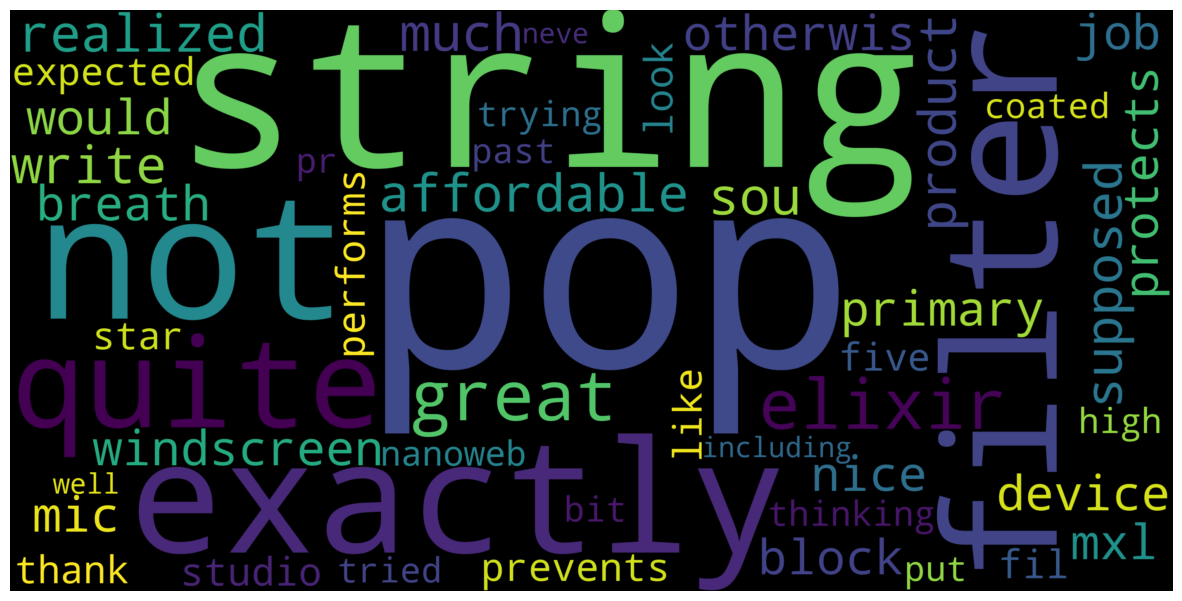

In [70]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Word Cloud of Reviews with Neutral Sentiments



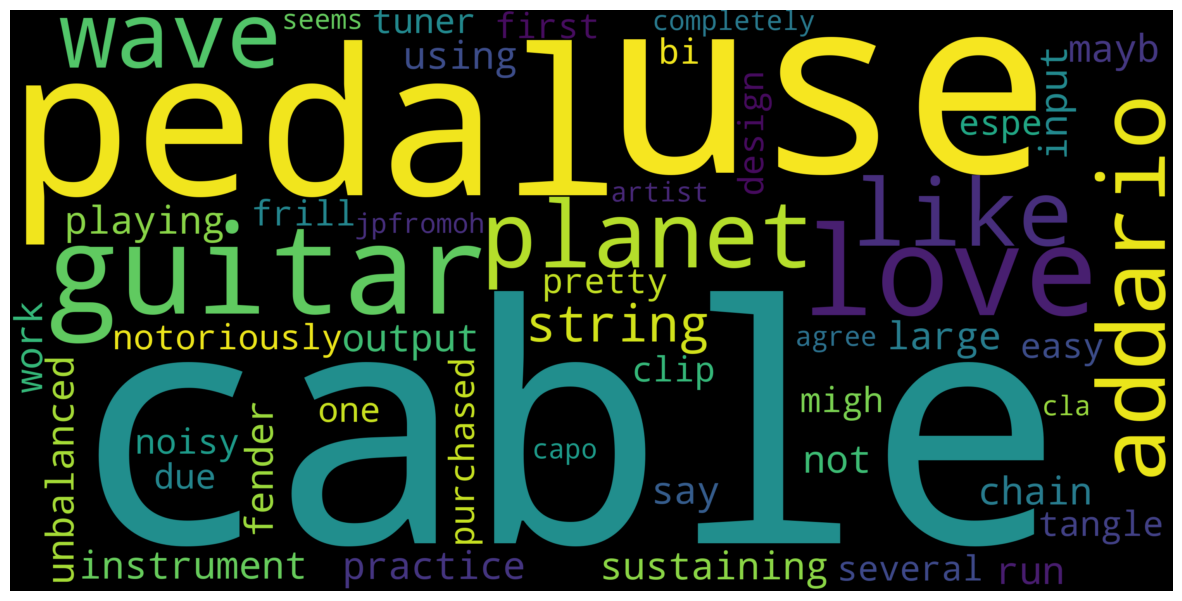

In [71]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Word Cloud of Reviews with Negative Sentiments



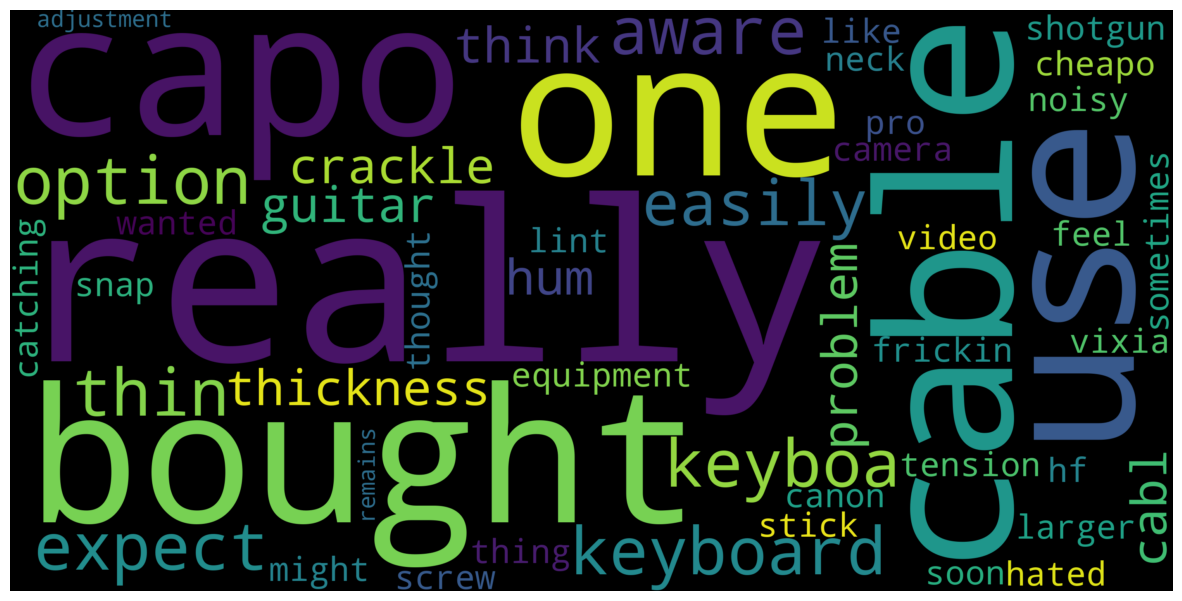

In [72]:

wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

From these word clouds, not only we can see words that really describe our sentiments, but just like our N-Grams Analysis we can see objects being discussed in the reviews given.

---


# Feature Engineering
### Drop Insignificant Columns

In [73]:

Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

We dropped these columns to make our dataset concise. We now have two columns as our independent variables and the last column as dependent variables. To continue, we must encode our label as a set of numbers corresponding to each categories of it.

### Current State of dataset

In [74]:
dataset.head()

,reviews,sentiment,word_count
0,not much write exactly supposed filter pop sou...,Positive,25
1,product exactly quite affordable not realized ...,Positive,54
2,primary job device block breath would otherwis...,Positive,45
3,nice windscreen protects mxl mic prevents pop ...,Positive,23
4,pop filter great look performs like studio fil...,Positive,18


### Encoding Our Target Variable



In [75]:
Encoder = LabelEncoder()

dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])


In [76]:
dataset["sentiment"].value_counts()

sentiment
2    9022
1     772
0     467
Name: count, dtype: int64

We had successfully encoded our sentiment into numbers so that our model can easily figure it out. From above, we know that the label Positive is encoded into 2, Neutral into 1, and Negative into 0. Now, we have to give importance of each words in the whole review, i.e. giving them weights. We can do this by using TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.

### TF-IDF Vectorizer



In [77]:

# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [78]:

# Declaring our target variable
y = dataset["sentiment"]
     

From the shape, we successfully transformed our reviews with TF-IDF Vectorizer of 7000 top bigram words. Now, as we know from before, our data is kind of imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modelling process.

### Resampling Our Dataset

There are many ways to do resampling to an imbalanced dataset, such as SMOTE and Bootstrap Method. We will use SMOTE (Synthetic Minority Oversampling Technique) that will randomly generate new replicates of our undersampling data to balance our dataset.



In [79]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

In [82]:
Balancer = SMOTE(random_state= 42)
X_final , y_final = Balancer.fit_resample(X,y)

In [83]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

Now our data is already balanced as we can see from the counter of each sentiment categories before and after the resampling with SMOTE.



### Splitting Our Dataset



In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)


### We splitted our dataset into 75:25 portion respectively for the training and test set.



--- 

# Modeling selection and evaluation

We do not really know what is the best model that fits our data well. Because of that, we will need to try every classification models available and find the best models using the Confusion Matrix and F1 Score as our main metrics, and the rest of the metrics as our support. First, we should do some cross validation techniques in order to find the best model.

### Model Building

We are using K-Fold Cross Validation on our early dataset (before resampling) because the CV itself is not affected by the imbalanced dataset as it splits the dataset and takes into account every validations. If we use the CV on the balanced dataset that we got from resampling we should be able to get similar result.

In [85]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))
    

Decision Tree Test Accuracy: 0.8188277140975343
Logistic Regression Test Accuracy: 0.8818828283518491
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.8773999669735846
Naive Bayes Test Accuracy: 0.8091794454219505
K-Neighbors Test Accuracy: 0.8799336055165503


We got six models on our sleeves and from the results of 10-Fold Cross Validation, we know that the Logistic Regression model is the best model with the highest accuracy, slightly beating the SVC. Because of this, we will use the best model in predicting our sentiment, also to tune our parameter and evaluate the end-result of how well the model works.

### Hyperparameter Tuning



In [88]:

Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2'], "solver": ['liblinear']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 92.46 %
Best Parameters: {'C': 24.420530945486497, 'penalty': 'l2', 'solver': 'liblinear'}


We got a nice accuracy on our training set, which is 92.46% and from our Grid Search, we are also able to find our optimal hyperparameters. 

It is time to finish our model using these parameters to get the best model of Logistic Regression.

---

### Best Model



In [96]:

Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2' , solver="liblinear")
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)
     

Now that our model is done, we will test our model on our test set. The metrics that we will evaluate is based on this prediction that we made here.

### Metrics

Accuracy On Test Set

In [97]:
accuracy_score(y_test , Prediction)

0.9156199202009753

Really high accuracy that we got here, 91.56%. Still, we need to look out for the Confusion Matrix and F1 Score to find out about our model performance.

### Confusion Matrix

In [98]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)


### Visualizing Our Confusion Matrix



In [99]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")
  
  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)
     

Unnormalized Confusion Matrix


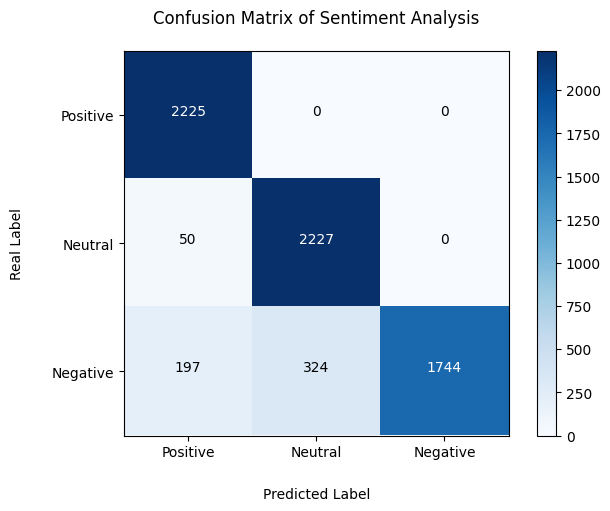

In [100]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")


What we can gain from the Confusion Matrix above is that the model overall works well. It is able to categorize both positive and neutral sentiments correctly, while it seems to struggle a bit at determining negative sentiments. Of course, this is the effect of imbalanced data that we got from our original dataset, and luckily we can minimize the effect thanks to our SMOTE resampling before.

### Classification Scores



In [101]:
print(classification_report(y_test, Prediction))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2225
           1       0.87      0.98      0.92      2277
           2       1.00      0.77      0.87      2265

    accuracy                           0.92      6767
   macro avg       0.92      0.92      0.91      6767
weighted avg       0.92      0.92      0.91      6767



Overall, to each of our sentiment categories, we got F1 Score of 91%, which is great and because of that we can conclude that our model works well on the dataset.

---

# Conclusion

## Dataset

Our dataset contains many features about user reviews on musical instruments. However, we rarely need those features as model variables because they are not crucial for sentiment analysis. 

We might omit the removal of stopwords in our preprocessing phase, as there could be important words that help determine user sentiments. From our text analysis, we know that most transactions are related to guitars or other string-based instruments. This indicates that guitars receive significant attention from customers, and sellers can emphasize their products on these instruments.

## Model

We tested almost all available classification models. Using 10-Fold Cross Validation, we found that the Logistic Regression Model achieved the best accuracy. Therefore, we decided to use and tune this model.

Our predictions on the test set also yielded good accuracy and a high F1 Score, indicating that our model performs well in sentiment analysis. We need to consider using more Cross Validation Methods, such as Stratified K-Fold, to avoid the need for resampling our dataset. While data scaling is not essential, it is highly recommended.

## Sources of Learning

These articles and notebooks are excellent resources for sentiment analysis and NLP:

- [Text Preprocessing in Python: Steps, Tools, and Examples](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)
- [Sentiment Analysis — ML project from Scratch to Production (Web Application)](https://pub.towardsai.net/sentiment-analysis-from-scratch-to-production-web-api-3382f19748e8)
- [Updated Text Preprocessing techniques for Sentiment Analysis](https://towardsdatascience.com/updated-text-preprocessing-techniques-for-sentiment-analysis-549af7fe412a)
- [Amazon Instrument: Sentimental Analysis](https://www.kaggle.com/code/nayansakhiya/amazon-instrument-sentimental-analysis)
- [Sentiment Analysis | Amazon reviews](https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews#Story-Generation-and-Visualization-from-reviews)
- [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

### Other Documentations:

- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Scikit-Learn](https://scikit-learn.org/)
- [Natural Language Toolkit](https://www.nltk.org/)
